# Workbook

In [1]:
# import necessary packages

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
import pathlib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# import numba
import seaborn as sns
import tensorflow as tf

from IPython import display
import tensorflow as tf
import pandas as pd
import librosa 

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-11-17 00:22:16.272047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 00:22:16.436354: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 00:22:16.586465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731802936.791466  127821 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731802936.838584  127821 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 00:22:17.288301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
audio_path = 'dataset/AUDIO_NEW/'
audio_types = ['breathing', 'cough', 'speech']

In [3]:
def get_directories(audio_path, audio_type):
    from pathlib import Path
    
    POS = os.path.join(audio_path + audio_type, 'COVID_Positive')
    NEG = os.path.join(audio_path + audio_type, 'COVID_Negative')

    # Specify the directory path
    pos_directory = Path(POS)
    neg_directory = Path(NEG)
    
    # List all files in the directory using iterdir()
    # pos_files = [file.name for file in pos_directory.iterdir() if file.is_file()]
    # neg_files = [file.name for file in neg_directory.iterdir() if file.is_file()]

    return pos_directory, neg_directory

### breathing mel spectrogram

In [4]:
pos_directory_breathing, neg_directory_breathing = get_directories(audio_path, audio_types[0])

In [5]:
def create_mel_spectrogram(y, sr, file_path):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize the spectrogram
    if np.std(log_mel_spectrogram) == 0:
        print("log_mel_spectrogram == 0: ", file_path.resolve())
    # Normalize the spectrogram
    epsilon = 1e-6  # Small value to avoid division by zero
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)

    # Add channel dimension
    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  
    
    return log_mel_spectrogram
def create_zero_crossing_rate(y):
    return np.mean(librosa.feature.zero_crossing_rate(y))
def create_spectral_centroid(y, sr):
    return np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

In [6]:
def create_features(pos_directory, neg_directory, target_length):
    spectrograms = []
    other_features = []
    labels = []

    for file_path in pos_directory.iterdir():
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding],axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])


        labels.append(1)
    for file_path in neg_directory.iterdir():
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding],axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])

        labels.append(0)

    print("Completed creating features for {0} and {1}! ".format(pos_directory, neg_directory))
    
    return spectrograms, other_features, labels

In [7]:
spectrograms, other_features, labels = create_features(pos_directory_breathing, neg_directory_breathing, 80000)

log_mel_spectrogram == 0:  /workspaces/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/TMWZXJNT.flac
log_mel_spectrogram == 0:  /workspaces/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/GDOLSUHV.flac
log_mel_spectrogram == 0:  /workspaces/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/HTUZHMVC.flac
Completed creating features for dataset/AUDIO_NEW/breathing/COVID_Positive and dataset/AUDIO_NEW/breathing/COVID_Negative! 


In [8]:
# # List to store spectrograms and labels
# spectrograms = []
# zero_crossing_rates = []
# spectral_centroids = []
# labels = []

# for file_path in pos_directory.iterdir():
#     y, sr = librosa.load(file_path.resolve(), sr=16000)
#     y = y[:80000]

#     zero_padding = np.zeros(80000 - len(y), dtype=np.float32)
#     y = np.concatenate([y, zero_padding],axis=0)
    
#     mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
#     log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

#     # Normalize the spectrogram
#     log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / np.std(log_mel_spectrogram)

#     log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension

#     # Append to list
#     spectrograms.append(log_mel_spectrogram)
    
#     zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
#     spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    
#     zero_crossing_rates.append(zero_crossing_rate)
#     spectral_centroids.append(spectral_centroid)
    
#     labels.append(1)  # Assuming binary classification

# for file_path in neg_directory.iterdir():
#     y, sr = librosa.load(file_path.resolve(), sr=16000)
#     y = y[:80000]

#     zero_padding = np.zeros(80000 - len(y), dtype=np.float32)
#     y = np.concatenate([y, zero_padding],axis=0)
    
#     mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
#     log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

#     if np.std(log_mel_spectrogram) == 0:
#         print(file_path.resolve())
#     # Normalize the spectrogram
#     epsilon = 1e-6  # Small value to avoid division by zero
#     log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)
    
#     log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)  # Add channel dimension
#     #print(log_mel_spectrogram.shape)
#     # Append to list
#     spectrograms.append(log_mel_spectrogram)

#     zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
#     spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    
#     zero_crossing_rates.append(zero_crossing_rate)
#     spectral_centroids.append(spectral_centroid)
    
#     labels.append(0)  

In [9]:
spectrograms = np.array(spectrograms)
other_features = np.array(other_features)
spectrograms_flattened = spectrograms.reshape(spectrograms.shape[0], -1)

In [10]:
spectrograms.shape

(965, 128, 626, 1)

In [11]:
spectrograms

array([[[[-1.0245274 ],
         [-1.0245274 ],
         [-1.0245274 ],
         ...,
         [-1.0245274 ],
         [-1.0245274 ],
         [-0.585717  ]],

        [[-1.0245274 ],
         [-1.0245274 ],
         [-1.0245274 ],
         ...,
         [-0.7121069 ],
         [-0.61760294],
         [-0.47910306]],

        [[-1.0245274 ],
         [-1.0245274 ],
         [-1.0245274 ],
         ...,
         [-0.5925574 ],
         [-0.49615926],
         [-0.40816563]],

        ...,

        [[-1.0245274 ],
         [-1.0245274 ],
         [-1.0245274 ],
         ...,
         [-0.65365595],
         [-0.8019026 ],
         [-0.7642045 ]],

        [[-1.0245274 ],
         [-1.0245274 ],
         [-1.0245274 ],
         ...,
         [-0.80553174],
         [-0.88778615],
         [-0.8569028 ]],

        [[-1.0245274 ],
         [-1.0245274 ],
         [-1.0245274 ],
         ...,
         [-1.0245274 ],
         [-1.0245274 ],
         [-0.875685  ]]],


       [[[-0.8499598 ],


In [12]:
spectrograms_flattened

array([[-1.0245274 , -1.0245274 , -1.0245274 , ..., -1.0245274 ,
        -1.0245274 , -0.875685  ],
       [-0.8499598 , -0.8499598 , -0.8499598 , ..., -0.8499598 ,
        -0.8499598 , -0.8499598 ],
       [-1.4920827 , -0.49222827, -1.0439658 , ..., -1.4920827 ,
        -1.4920827 , -1.4920827 ],
       ...,
       [-0.82291603, -0.82291603, -0.82291603, ..., -0.82291603,
        -0.82291603, -0.82291603],
       [-0.02960318,  0.15267141,  0.4176892 , ...,  0.30274767,
         0.32243147,  0.29757768],
       [-0.8441308 , -0.8441308 , -0.8441308 , ..., -0.19108425,
        -0.30054775, -0.25943556]], dtype=float32)

In [13]:
X_combined = np.hstack([spectrograms_flattened, other_features])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, stratify=labels)

In [15]:
X_combined[0]

array([-1.02452743e+00, -1.02452743e+00, -1.02452743e+00, ...,
       -8.75684977e-01,  3.11420805e-01,  2.72697328e+03])

In [16]:
# Flatten each spectrogram into a single vector
# Resulting shape will be (num_samples, height * width * channels)
# X_train_numpy = np.array(X_train)
# X_train_flattened = X_train_numpy.reshape(X_train_numpy.shape[0], -1)

# print(f"Original shape: {X_train_numpy.shape}")
# print(f"Flattened shape: {X_train_flattened.shape}")

In [17]:
# from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTEENN
from collections import Counter

smote_enn = SMOTEENN(random_state=seed)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Print resampled class distribution
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

Resampled class distribution: Counter({1: 612, 0: 204})


In [18]:
# from imblearn.combine import SMOTEENN
# from collections import Counter

# smote_enn = SMOTEENN(random_state=seed)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train_flattened, y_train)

# # Print resampled class distribution
# print(f"Resampled class distribution: {Counter(y_resampled)}")

In [19]:
# # Reshape back to original format after resampling
# X_resampled = X_resampled.reshape(X_resampled.shape[0], 128, 626, 1)

# print(f"Reshaped back to original format: {X_resampled.shape}")

In [20]:
num_spectrogram_features = 128 * 626  # Flattened size

In [21]:
# Separate resampled spectrograms and other features for X_train_resampled
spectrograms_resampled = X_train_resampled[:, :num_spectrogram_features]
other_features_resampled = X_train_resampled[:, num_spectrogram_features:]

In [22]:
spectrograms_resampled

array([[-2.71405005, -2.71405005, -2.71405005, ..., -1.12689137,
        -1.29892433, -1.11307275],
       [-1.26715827, -1.26715827, -1.26715827, ..., -0.90700018,
        -0.90341783, -0.90711761],
       [-1.74985254, -0.75055051, -0.59330642, ..., -3.20076823,
        -2.20796299, -1.63982832],
       ...,
       [-1.54852112, -1.54852112, -1.54852112, ..., -1.54852112,
        -1.54852112, -1.54852112],
       [-1.61941074, -1.459159  , -1.30059798, ..., -2.30758786,
        -2.0826856 , -1.89605621],
       [-0.88937786, -0.88937786, -0.88937786, ..., -0.88937786,
         0.08831641,  0.43308856]])

In [23]:
# Reshape the flattened spectrograms back to their original shape (128x626)
spectrograms_resampled_reshaped = spectrograms_resampled.reshape(spectrograms_resampled.shape[0], 128, 626, 1)

In [24]:
# Optionally add a channel dimension for CNN input (e.g., shape: [samples, 128, 626, 1])
#spectrograms_resampled_reshaped = np.expand_dims(spectrograms_resampled_reshaped, axis=-1)

In [25]:
spectrograms_resampled_reshaped.shape

(816, 128, 626, 1)

In [26]:
other_features_resampled.shape

(816, 2)

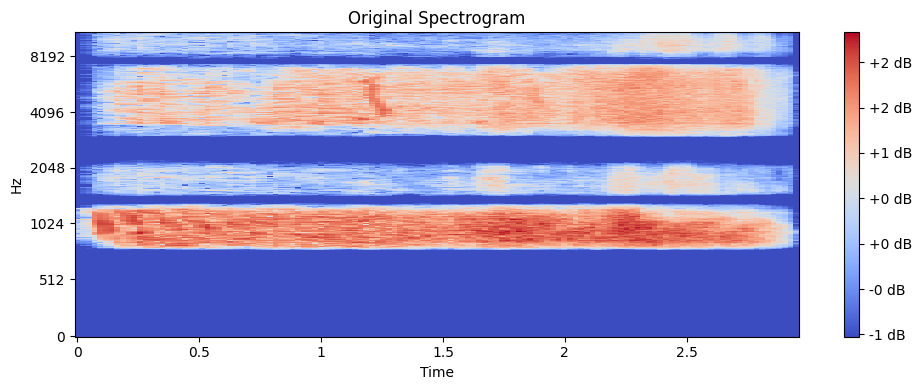

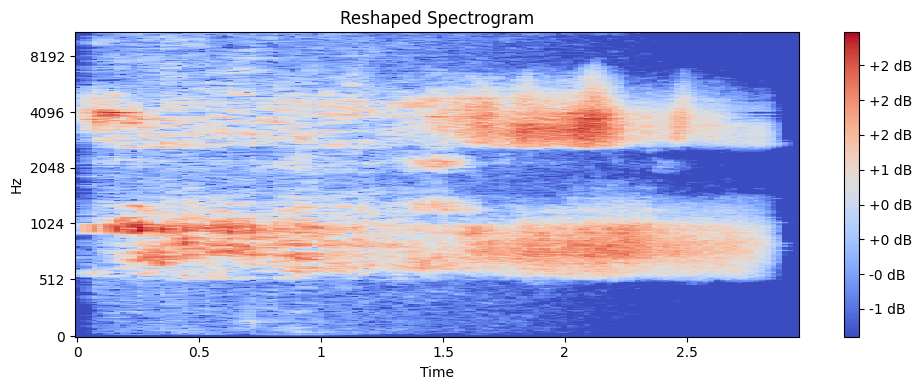

In [27]:
import matplotlib.pyplot as plt
import librosa.display

# Function to plot spectrogram
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(10, 4))
    # Remove channel dimension if present for visualization
    if spectrogram.shape[-1] == 1:
        spectrogram = spectrogram.squeeze(-1)
    librosa.display.specshow(spectrogram.T, sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Assuming 'original_spectrogram' is your original unflattened spectrogram
# and 'reshaped_spectrogram' is your reshaped version after processing

# Plot original spectrogram (before flattening)
plot_spectrogram(spectrograms[0], "Original Spectrogram")

# Plot reshaped spectrogram (after reshaping back)
plot_spectrogram(spectrograms_resampled_reshaped[100], "Reshaped Spectrogram")


In [28]:
# For X_test (no resampling needed), separate and reshape the spectrograms
spectrograms_test = X_test[:, :num_spectrogram_features]
other_features_test = X_test[:, num_spectrogram_features:]
spectrograms_test_reshaped = spectrograms_test.reshape(spectrograms_test.shape[0], 128, 626, 1)

In [29]:
y_train_resampled = np.array(y_train_resampled)
y_test = np.array(y_test)

In [30]:
# y_resampled = np.array(y_resampled)

### Single input model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D

In [32]:
model = Sequential()
model.add(Input(shape=(625,128,1)))

# First Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Reduces spatial dimensions by half

# Second Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Third Conv2D layer followed by MaxPooling
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Fourth Conv2D layer followed by MaxPooling (new)
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Flatten and Dense layers
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2024-11-17 00:23:25.141828: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [33]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 623, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 311, 63, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 309, 61, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 154, 30, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 152, 28, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 76, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 74, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 37, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,065 (133.07 KB)

 Trainable params: 34,065 (133.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(X_train_resampled, y_train_resampled, batch_size=8, verbose=2, epochs=20, validation_split=0.1)


### Fit Model, View Loss and KPI Plots

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

y_pred = model.predict(X_test)

2024-11-17 00:23:25.488475: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 61860360 exceeds 10% of free system memory.


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 80130), dtype=float32). Expected shape (None, 625, 128, 1), but input has incompatible shape (32, 80130)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 80130), dtype=float32)
  • training=False
  • mask=None

: 

In [ ]:
y_pred_binary = (y_pred > 0.99).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_binary)

In [ ]:
len(y_test)

In [ ]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

### Multi-input model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout

# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input = Input(shape=(128, 626, 1), name='mel_spectrogram')

# Define CNN sub-network for Mel spectrogram
x = Conv2D(16, (3,3), activation='relu')(mel_input)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = GlobalAveragePooling2D()(x)

# Define input for other features (e.g., zero-crossing rate and spectral centroid)
other_input = Input(shape=(2,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([x, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [ ]:
X_train_spectrograms = spectrograms_resampled_reshaped
X_train_others = other_features_resampled
y_train = y_train_resampled

In [ ]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
model.summary()

In [ ]:
history = model.fit(
    [X_train_spectrograms,
     X_train_others],
    y_train,
    validation_split = 0.1,
    verbose = 2,
    epochs=20,
    batch_size=16
)

In [ ]:
X_train_spectrograms.shape

In [ ]:
X_train_others

In [ ]:
y_pred_train = model.predict([X_train_spectrograms, X_train_others])

In [ ]:
y_pred_train_binary = (y_pred_train > 0.99).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_train = accuracy_score(y_train, y_pred_train_binary)

In [ ]:
accuracy_train

In [ ]:
cm = confusion_matrix(y_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [ ]:
y_pred_test = model.predict([spectrograms_test_reshaped, other_features_test])

In [ ]:
y_pred_test_binary = (y_pred > 0.99).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test_binary)

In [ ]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_test = accuracy_score(y_test, y_pred_test_binary)

In [ ]:
accuracy_test